<a href="https://colab.research.google.com/github/Kevinouio/MSU-AI-Building-Classification/blob/main/AI_Model_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Including necessary libraries and file paths.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from google.colab import drive
from tensorflow.keras.models import load_model

# Path to your saved model (replace with the actual path)
model_path = '/content/drive/MyDrive/ModelsRes/model_epoch_12.h5'

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your Google Drive folder
drive_folder = '/content/drive/MyDrive/CheckpointsResNet50/'

# Define the path to save the models
model_save_folder = '/content/drive/MyDrive/ModelsRes/'

# Create the folder if it doesn't exist
if not os.path.exists(model_save_folder):
    os.makedirs(model_save_folder)

# Create the folder if it doesn't exist
if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)

Define Custom Callbacks

In [ ]:
class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_generator, class_indices):
        super().__init__()
        self.validation_generator = validation_generator
        self.class_indices = class_indices
        self.class_names = list(class_indices.keys())  # List of class names

    def on_epoch_end(self, epoch, logs=None):
        # Predict on validation data
        val_labels = self.validation_generator.classes
        val_preds = self.model.predict(self.validation_generator)
        val_pred_classes = np.argmax(val_preds, axis=1)

        # Confusion matrix
        cm = confusion_matrix(val_labels, val_pred_classes)

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title(f'Confusion Matrix after Epoch {epoch + 1}')
        plt.show()


class ResetValidationDataCallback(Callback):
    def __init__(self, validation_datagen, data_dir, img_height, img_width, batch_size):
        super().__init__()
        self.validation_datagen = validation_datagen
        self.data_dir = data_dir
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.epoch_counter = 0  # Keeps track of the epochs

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_counter += 1
        # Change validation data after every 12 epochs
        if self.epoch_counter % 10 == 0:
            print(f'Changing validation data at epoch {epoch + 1}')
            # Reload the validation data
            self.model.validation_data = self.validation_datagen.flow_from_directory(
                self.data_dir,
                target_size=(self.img_height, self.img_width),
                batch_size=self.batch_size,
                class_mode='categorical',
                subset='validation'
            )


class SaveBestEveryEpoch(Callback):
    def __init__(self, save_dir, verbose=1):
        super(SaveBestEveryEpoch, self).__init__()
        self.save_dir = save_dir
        self.verbose = verbose
        self.best_loss = np.inf
        self.block_counter = 1  # Keeps track of 5-epoch blocks
        self.best_weights = None  # Best weights for each block

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')

        # Save the model for the current epoch
        model_save_path = os.path.join(self.save_dir, f'model_epoch_{epoch + 1}.h5')
        self.model.save(model_save_path)

        if self.verbose:
            print(f"\nModel saved at the end of Epoch {epoch + 1} with val_loss: {current_loss:.4f}")

        # Track and save the best model within the current 5-epoch block
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

        # After every 5th epoch, save the best model in the block and reset
        if (epoch + 1) % 5 == 0:
            block_save_path = os.path.join(self.save_dir, f'best_model_block_{self.block_counter}.h5')
            self.model.set_weights(self.best_weights)  # Set the model to the best weights in this block
            self.model.save(block_save_path)

            if self.verbose:
                print(f"\nBest model from block {self.block_counter} saved with val_loss: {self.best_loss:.4f}")

            # Reset for the next block
            self.block_counter += 1
            self.best_loss = np.inf  # Reset best loss for the next block
            self.best_weights = None  # Reset best weights for the next block

Train and preprocess the dataset

In [ ]:
# Load the dataset
data_dir = '/content/drive/MyDrive/AIDataset'
img_height, img_width = 512, 512
batch_size = 32

# Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data will be used for validation
)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Number of classes
num_classes = len(train_generator.class_indices)

Define ResNet34 Model

In [ ]:
# Define a custom ResNet34 architecture
def ResNet34(input_shape=(512, 512, 3), classes=10):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=input_shape
    )  # Use ResNet50 and customize the number of layers to mimic ResNet34

    # Remove deeper layers to simulate ResNet34
    base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[-34].output)

    return base_model

# Define the full model structure using ResNet34
base_model = ResNet34(input_shape=(img_height, img_width, 3), classes=num_classes)


if os.path.exists(model_path):
    model = load_model(model_path)  # Load the complete model including architecture and weights
else:
    base_model = ResNet34(input_shape=(img_height, img_width, 3), classes=num_classes)
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])



# Compile the model with the custom learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train Model

In [ ]:
# Define learning rate scheduler
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_data, class_indices):
        super().__init__()
        self.validation_data = validation_data  # Generator
        self.class_indices = class_indices  # Class mapping

    def on_epoch_end(self, epoch, logs=None):
        val_labels = self.validation_data.classes  # True labels from validation set
        val_preds = self.model.predict(self.validation_data)  # Predictions for validation set
        val_preds_classes = np.argmax(val_preds, axis=1)  # Convert predictions to class labels

        # Compute confusion matrix
        cm = confusion_matrix(val_labels, val_preds_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_indices)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix after Epoch {epoch + 1}')
        plt.show()


# Validation data generator (to be reshuffled)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Include the ResetValidationDataCallback in your training
reset_val_callback = ResetValidationDataCallback(
    validation_datagen=validation_datagen,
    data_dir=data_dir,
    img_height=img_height,
    img_width=img_width,
    batch_size=batch_size
)

# Initialize the SaveBestEvery5Epochs callback
save_best_callback = SaveBestEveryEpoch(save_dir=model_save_folder)

# Initialize the confusion matrix callback
conf_matrix_callback = ConfusionMatrixCallback(
    validation_data=validation_generator,  # This is your validation data generator
    class_indices=train_generator.class_indices  # This is the mapping of classes to indices
)


# Train the model with the additional callback
history = model.fit(
    train_generator,
    epochs=30,
    initial_epoch=12,
    validation_data=validation_generator,
    callbacks=[save_best_callback, lr_reducer, reset_val_callback, conf_matrix_callback]  # Add confusion matrix callback
)



# Save final model
final_model_path_h5 = os.path.join(drive_folder, 'building_classifier_final.h5')
model.save(final_model_path_h5)


Validating on full dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 10193 images belonging to 10 classes.
40/40 [==============================] - 4245s 107s/step


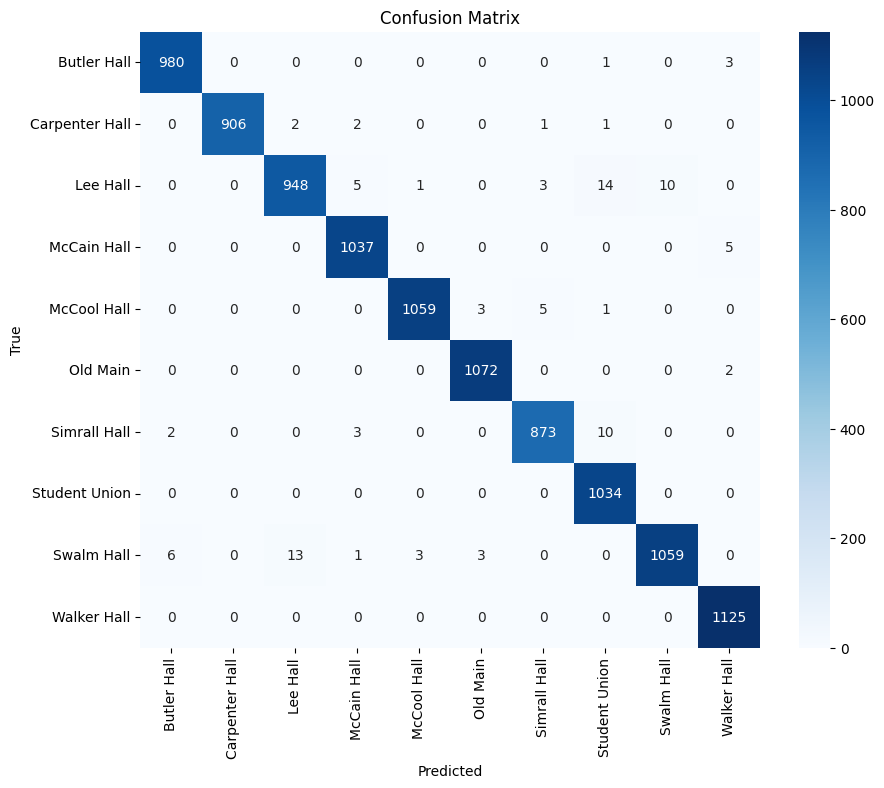

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import google.colab.drive as drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your Google Drive folder
drive_folder = '/content/drive/MyDrive/Checkpoints/'

# Load the trained model
model_path = '/content/drive/MyDrive/ModelsRes/model_epoch_17.h5'  # Path to your saved model
model = tf.keras.models.load_model(model_path)

# Define image dimensions and batch size
img_height, img_width = 512, 512  # Adjust based on your model input
batch_size = 256

# Load the test dataset without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/AIDataset',  # Path to your test dataset
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Change if using binary classification
    shuffle=False  # Important for confusion matrix
)

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = tf.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
